In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_wavelength_at_max(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for tag, y in zip(f['/bunches'], arr):
                yield {"tag": tag, "atmax": x[np.argmax(y)]}
        except KeyError:
            return


def read_tof(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'tof': tof.astype('double')}
                        for tag, tof
                        in zip(f['/bunches'],
                               f['/digitizer/channel1']))
        except KeyError:
            return

In [3]:
run = 64
filenames = sorted(fn for fn in set(iglob(f"/data/TwoPulses/Run_{run:03d}/rawdata/*.h5")) if is_available(fn))
bg_period, bg_mod = 3, 0  # /Background_Period

integ = (
    from_sequence(filenames)
    .map(read_tof)
    .flatten()
    .to_dataframe()
)
integ['is_bg'] = integ['tag'] % bg_period == bg_mod
integ

,tag,tof,is_bg
npartitions=100,,,
,int64,object,bool
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [4]:
with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg,
                'count': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().count()),
                'summed': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().sum()),
            }
            for bg in [True, False]
        ],
    )

summed = pd.DataFrame(list(summed)).set_index('is_bg')
summed

[########################################] | 100% Completed |  1min 13.3s


,count,summed
is_bg,,
True,10000,"[4419932.0, 4419847.0, 4419974.0, 4419772.0, 4..."
False,20000,"[8839805.0, 8839660.0, 8839705.0, 8839620.0, 8..."


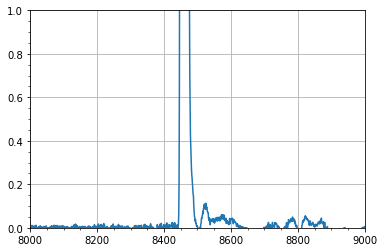

In [5]:
avg = (
    summed.loc[False, 'summed'] / summed.loc[False, 'count']
    - summed.loc[True, 'summed'] / summed.loc[True, 'count']
)
plt.plot(-avg)
plt.xlim(8000, 9000)
plt.ylim(0, 1)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [6]:
def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            _, n = f["/photon_diagnostics/Spectrometer/hor_spectrum"].shape
            x = a * (np.arange(n) - x0) + x1

            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'tof_intensity': tof[8400:8500].sum(),
                         'delay': round(dt, 2),
                         'atmax': x[np.argmax(hor)]}
                        for tag, iom, tof, dt, hor
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'],
                               f['/digitizer/channel1'],
                               f['/user_laser/delay_line/position'],
                               f["/photon_diagnostics/Spectrometer/hor_spectrum"]))
        except KeyError:
            return


with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_scala)
        .flatten()
        .to_dataframe()
        .compute()
    )
df = df.set_index("tag").sort_index()
df

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 54.0s


,atmax,delay,iom_intensity_pc,tof_intensity
tag,,,,
478454535,50.687243,-5.92,361.951447,44208
478454536,50.692070,-5.92,399.349594,43324
478454537,50.680002,-5.92,399.404526,43832
478454538,50.692070,-5.92,457.367706,44210
478454539,50.689657,-5.92,409.585762,43282
478454540,50.687243,-5.92,400.352097,43293
478454541,50.687243,-5.92,405.759430,44213
478454542,50.692070,-5.92,396.225357,43452
478454543,50.689657,-5.92,366.304779,43390


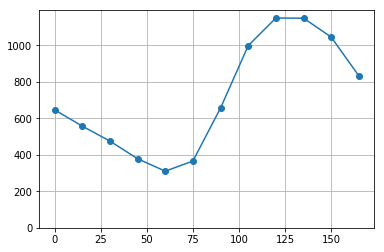

In [16]:
df['is_bg'] = df.index % bg_period == bg_mod
df["phi"] = 1239.84193 / df["atmax"] % 0.0158 / 0.0158 * 2 * np.pi
df["binned"] = df["phi"].apply(np.digitize, bins=np.linspace(0, 2 * np.pi, 12+1))
groupped = df.groupby(['binned', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
plt.figure()
diff = -(
    (groupped.loc[pd.IndexSlice[:, False], 'sum'] / groupped.loc[pd.IndexSlice[:, False], 'count'])
        .reset_index(level=[1], drop=True)
    - (groupped.loc[pd.IndexSlice[:, True], 'sum'] / groupped.loc[pd.IndexSlice[:, True], 'count'])
        .reset_index(level=[1], drop=True)
)
plt.plot((diff.index - 1) / 24 * 360, diff, 'o-')
plt.ylim(0, None)
plt.grid(True)
plt.show()

In [17]:
groupped

count        sum
binned is_bg                  
1      False   2896  126114188
       True    1440   63640098
2      False   2246   98009901
       True    1172   51796317
3      False   1450   63393952
       True     680   30052820
4      False   1043   45699415
       True     560   24748567
5      False    495   21722080
       True     236   10429627
6      False    354   15515657
       True     154    6806080
7      False    333   14498067
       True     140    6187210
8      False    460   19870416
       True     254   11225490
9      False    795   34219992
       True     419   18517142
10     False   1350   58111421
       True     676   29875370
11     False   2009   86687263
       True     975   43089490
12     False   5436  235717602
       True    2727  120518676